In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin
from tools.freecode import load_quijote_halos, TruncatedPowerLaw

## fit halo bias quijote

In [2]:
def load_hhalos(snapdir):
    # load quijote halos and compute histogram
    pos_h, mass, _, _ = load_quijote_halos(snapdir)
    posm = np.concatenate([pos_h, np.log10(mass)[:, None]], axis=1)
    h, edges = np.histogramdd(
        posm,
        (128, 128, 128, 10),
        range=[(0, 1e3)]*3+[(12.8, 15.8)]
    )
    return h, edges

In [8]:
lhid=3

load_dir = f'/home/mattho/git/cmass-ili/data/quijote/source/density_field/latin_hypercube/{lhid}'
rho1g = np.load(pjoin(load_dir, 'df_m_128_z=0.npy'))
load_dir = f'/home/mattho/git/cmass-ili/data/quijote/source/Halos/latin_hypercube/{lhid}'
hhalos1g, edges = load_hhalos(load_dir)

In [13]:
law = TruncatedPowerLaw()
def load_bias_params(bias_path, lhid):
    # load the bias parameters for using the 1 Gpc Quijote sims
    popt = np.load(pjoin(bias_path, f'{lhid}.npy'))
    medges = np.load(pjoin(bias_path, 'medges.npy'))
    return popt, medges
bias_path = pjoin('data', 'quijote/bias_fit/LH_n=128')
popt, medges = load_bias_params(bias_path, lhid)

In [14]:
nmean = np.zeros_like(hhalos1g)
for i in range(10):
    nmean[...,i] = law.sample(rho1g, popt[i])

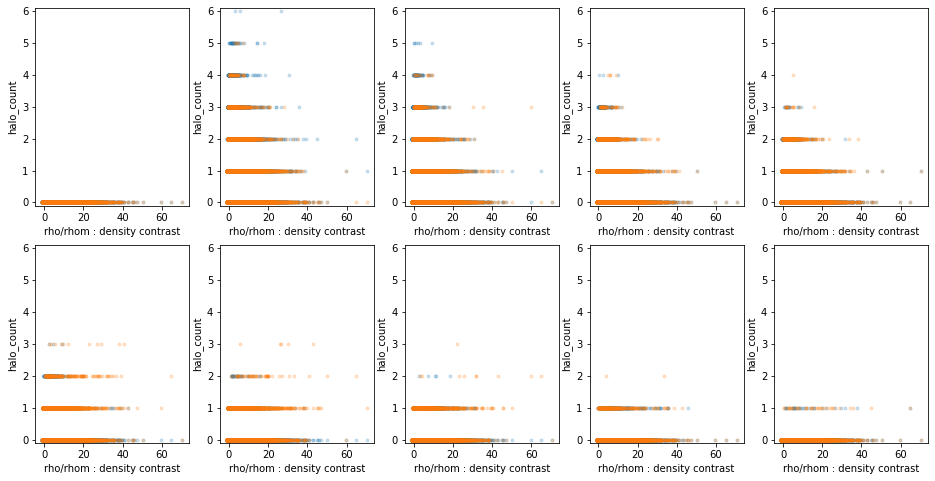

In [15]:
f = plt.figure(figsize=(16,8))
gs = mpl.gridspec.GridSpec(2,5)

for i in range(10):
    ax = f.add_subplot(gs[i//5, i%5])
    ax.plot(rho1g.flatten(), hhalos1g[...,i].flatten(),'.', label='true', alpha=0.2)
    ax.plot(rho1g.flatten(), nmean[...,i].flatten(),'.', label='sample', alpha=0.2)
    ax.set_xlabel('rho/rhom : density contrast')
    ax.set_ylabel('halo_count')
    ax.set_ylim(-0.1,6.1)

Text(0, 0.5, 'ngal_mean')

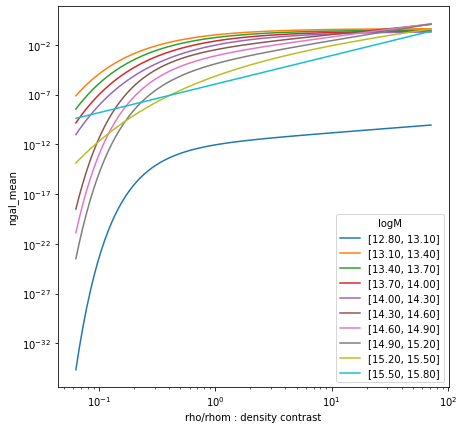

In [16]:
rholin = 10**np.linspace(np.log10(rho1g.min()+1), np.log10(rho1g.max()+1), 100)-1

f = plt.figure(figsize=(7,7))
plt.loglog()
for i in range(10):
    ngal_mean = law.predict(rholin, popt[i])
    plt.plot(rholin+1, ngal_mean, label=f"[{medges[i]:.2f}, {medges[i+1]:.2f}]")
    
plt.legend(title='logM')
plt.xlabel('rho/rhom : density contrast')
plt.ylabel('ngal_mean')

In [ ]:
# compare Pk

# calculate cross-correlation


In [44]:
medges = edges[-1]

## calculate cmass n(z)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.stats import scott_bin_width

from scipy.interpolate import InterpolatedUnivariateSpline

import pymangle
from os.path import join as pjoin

In [2]:
import nbodykit.lab as nblab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()
from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift, thetahod_literature

In [3]:
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = 'data/obs/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)

In [5]:
# apply selection and calculate area
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

In [11]:
cmass['Z'].values

array([0.46564791, 0.56580216, 0.61221063, ..., 0.44704831, 0.40994021,
       0.415804  ])

Text(0.5, 0, 'z')

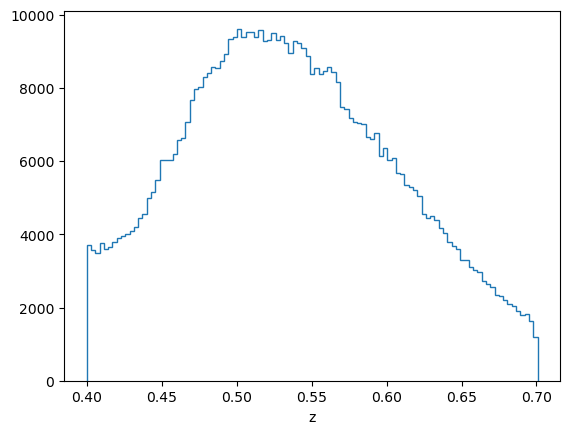

In [15]:
_, be = scott_bin_width(cmass['Z'].values, True)
h, _, _ = plt.hist(cmass['Z'], be, histtype='step')
plt.xlabel('z')

In [18]:
savepath = 'data/obs/n-z_DR12v5_CMASS_North.npy'
np.save(savepath,{'be':be, 'h':h})

## Premask randoms

In [1]:
from gals_to_summaries.calc_Pk_nbkit import load_randoms

randoms = load_randoms()

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


In [3]:
savepath = pjoin('data', 'obs', 'random0_DR12v5_CMASS_North_PRECOMPUTED.npy')
np.save(savepath, randoms)

## Calculate observed P(k)

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits

import pymangle
from os.path import join as pjoin
from gals_to_summaries.calc_Pk_nbkit import load_randoms_precomputed, compute_Pk

import nbodykit.lab as nblab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()
from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load survey
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = 'data/obs/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
mask *= BOSS_veto(cmass['RA'], cmass['DEC'], cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

crdz = np.stack([cmass['RA'], cmass['DEC'], cmass['Z']], axis=-1)

In [10]:
randoms = load_randoms_precomputed()
cosmo = cosmology.Planck15

# compute P(k)
k_gal, p0k_gal, p2k_gal, p4k_gal = compute_Pk(crdz, randoms, cosmo)

# save results
source_dir = 'data/obs'
outpath = pjoin(source_dir, 'Pk', 'Pk.npz')
np.savez(outpath, k_gal=k_gal, p0k_gal=p0k_gal,
            p2k_gal=p2k_gal, p4k_gal=p4k_gal)

/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


Text(0.5, 0, '$k$')

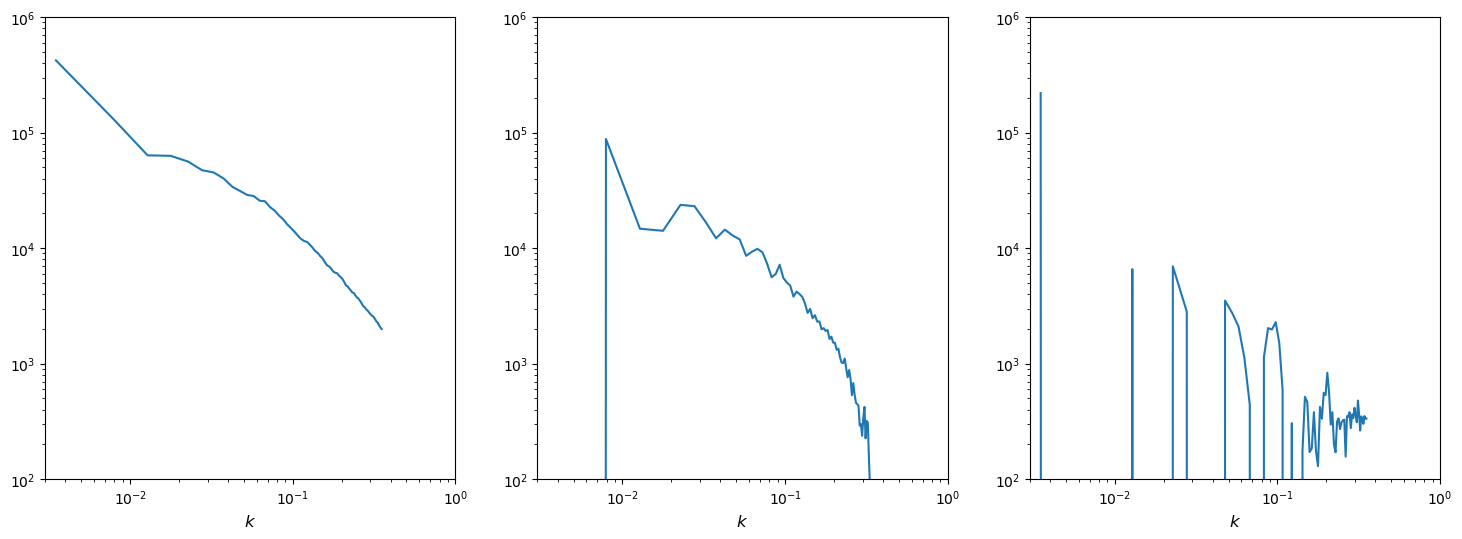

In [11]:
# plot all Pk
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].loglog()
axs[0].plot(k_gal, p0k_gal, label='galaxy')
axs[0].set_xlim([3e-3, 1.])
axs[0].set_ylim(1e2, 1e6)
axs[0].set_xlabel('$k$', fontsize=12)

axs[1].loglog()
axs[1].plot(k_gal, p2k_gal, label='galaxy')
axs[1].set_xlim([3e-3, 1.])
axs[1].set_ylim(1e2, 1e6)
axs[1].set_xlabel('$k$', fontsize=12)

axs[2].loglog()
axs[2].plot(k_gal, p4k_gal, label='galaxy')
axs[2].set_xlim([3e-3, 1.])
axs[2].set_ylim(1e2, 1e6)
axs[2].set_xlabel('$k$', fontsize=12)

## Scratch

In [4]:
import numpy as np
import jax
from cuboid_remap import remap_Lbox

In [5]:
Lbox = 3000
u1, u2, u3 = (1, 1, 0), (0, 0, 1), (1, 0, 0)

np.array(remap_Lbox(u1, u2, u3))*Lbox

array([4242.64068712, 3000.        , 2121.32034356])